In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
INTRON_FILE = 'introns.csv'
ESSENTIALITY_FILE = 'essentiality.csv'
ESSENTIALITY_DICT = {
    "Nonessential": 0,
    "Conditional": 1,
    "Essential": 2
}
num_lines = sum(1 for line in open(INTRON_FILE,'r'))

In [3]:
def get_essentialities():
    
    essentialities = {}
    
    num_lines_ess = sum(1 for line in open(ESSENTIALITY_FILE,'r'))
    with open(ESSENTIALITY_FILE) as f:
        # titles
        f.readline()

        for i in tqdm(range(num_lines_ess)):
            line = f.readline().split(",")

            # ignore empty lines
            if len(line) < 2:
                continue

            ess = line[1]
            # sanity check
            if ess in ESSENTIALITY_DICT:
                essentialities[line[0]] = ESSENTIALITY_DICT[ess]
    return essentialities

In [4]:
def intron_size_list(essentialities, essential_filter, only_first_intron=False, not_first_intron=False):
    intron_sizes = []
    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            intron_num = int(line[3])
            code = line[4][:-1]
            
            # Ignore non-first introns, if filter is set
            if only_first_intron and intron_num != 1:
                continue
            if not_first_intron and intron_num == 1:
                continue
            if gene in essentialities and essentialities[gene] == ESSENTIALITY_DICT[essential_filter]:
                intron_sizes.append(len(code))
    return intron_sizes

def plot_intron_size(essentialities, essential_filter, only_first_intron=False):
    sizes = intron_size_list(essential_filter)
    plt.figure(figsize=(20,4))
    plt.hist(sizes, bins=50, rwidth=0.9, range=(0,10000))
    plt.show()

In [5]:
essentialities = get_essentialities()

100%|██████████| 21557/21557 [00:00<00:00, 835133.94it/s]


In [6]:
all_ess = ["Essential", "Conditional", "Nonessential"]
all_intron_sizes = []
# calculate intron size by group for all introns and only first introns
for ess in all_ess:
    intron_sizes = intron_size_list(essentialities, ess)
    first_intron_sizes = intron_size_list(essentialities, ess, only_first_intron=True)
    not_first_intron_sizes = intron_size_list(essentialities, ess, not_first_intron=True)
    
    # append to list storing all data
    all_intron_sizes.append([intron_sizes, first_intron_sizes, not_first_intron_sizes])

100%|██████████| 248692/248692 [00:02<00:00, 88530.53it/s]


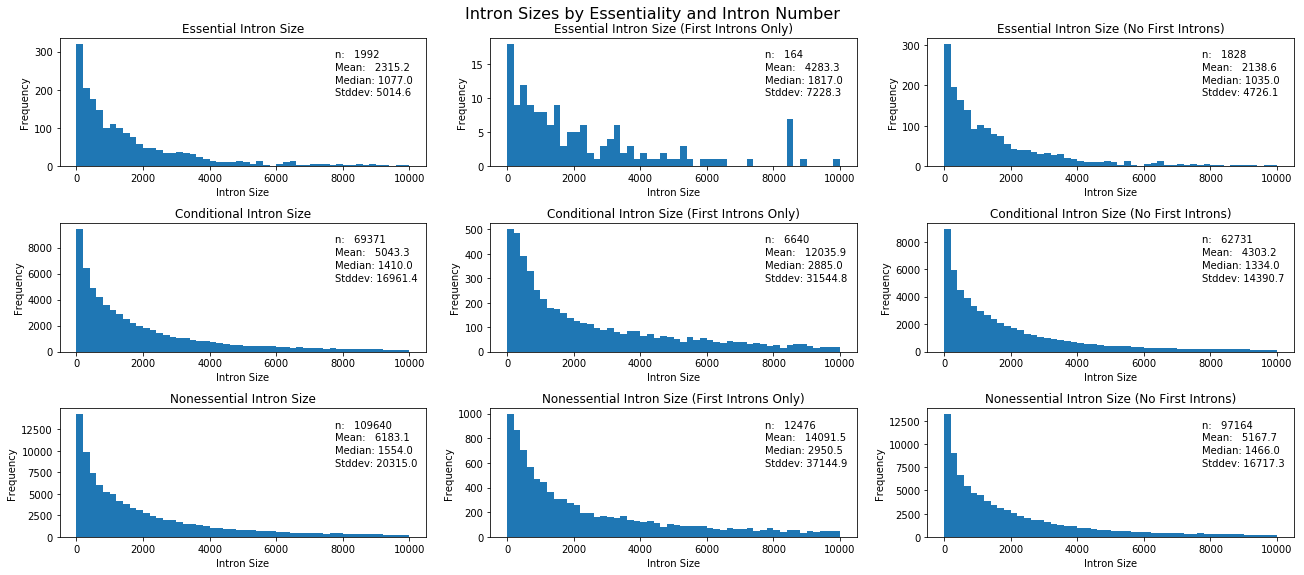

In [7]:

fig, axs = plt.subplots(3, 3, constrained_layout=True, figsize=(18,8))
for i, size_list in enumerate(all_intron_sizes):
    for j in range(3):
        axs[i][j].hist(all_intron_sizes[i][j], bins=50, rwidth=1, range=(0,10000))
        axs[i][j].set_xlabel('Intron Size')
        if j == 0:
            axs[i][j].set_title(all_ess[i] + ' Intron Size')
        elif j == 1:
            axs[i][j].set_title(all_ess[i] + ' Intron Size (First Introns Only)')
        else:
            axs[i][j].set_title(all_ess[i] + ' Intron Size (No First Introns)')
        axs[i][j].set_ylabel('Frequency')
        
        axs[i][j].text(0.75, 0.85, 'n:   ' + str(len(all_intron_sizes[i][j])), transform=axs[i][j].transAxes)
        axs[i][j].text(0.75, 0.75, 'Mean:   ' + str(round(np.mean(all_intron_sizes[i][j]), 1)), transform=axs[i][j].transAxes)
        axs[i][j].text(0.75, 0.65, 'Median: ' + str(round(np.median(all_intron_sizes[i][j]), 1)), transform=axs[i][j].transAxes)
        axs[i][j].text(0.75, 0.55, 'Stddev: ' + str(round(np.std(all_intron_sizes[i][j]), 1)), transform=axs[i][j].transAxes)
        
fig.suptitle('Intron Sizes by Essentiality and Intron Number', fontsize=16)
plt.show()

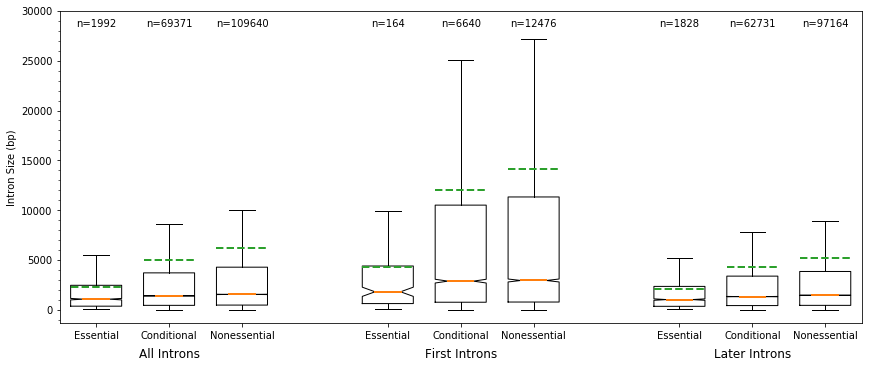

In [31]:
d = []
# for i, ess in enumerate(['Essential', 'Conditional', 'Nonessential']):
for i in range(3): #intron
    for k in range(3): #essentiality
        d.append(all_intron_sizes[k][i])

fig, ax = plt.subplots(constrained_layout=True, figsize=(12,5))

positions=[1, 2, 3, 5, 6, 7, 9, 10, 11]
labels = ['Essential', 'Conditional', 'Nonessential',
          'Essential', 'Conditional', 'Nonessential',
          'Essential', 'Conditional', 'Nonessential']

ax.boxplot(d, labels=labels, positions=positions, notch=True, showfliers=False, 
           showmeans=True, meanline=True, boxprops=dict(linewidth=1), medianprops=dict(linewidth=2),
           meanprops=dict(linewidth=2), widths=0.7) 
# Add n
for i in range(9):
    ax.text(positions[i], 0.95, 'n='+str(len(d[i])), horizontalalignment='center', transform=ax.get_xaxis_transform())

intron_desc = ["All Introns", "First Introns", "Later Introns"]
ax.text(positions[1], -0.11, 'All Introns', horizontalalignment='center', transform=ax.get_xaxis_transform(), size='large')
ax.text(positions[4], -0.11, 'First Introns', horizontalalignment='center', transform=ax.get_xaxis_transform(), size='large')
ax.text(positions[7], -0.11, 'Later Introns', horizontalalignment='center', transform=ax.get_xaxis_transform(), size='large')
    
# ax.set_xlabel('Gene Essentiality')
ax.set_ylabel('Intron Size (bp)')
ax.set_ylim(top=30000)

# ax.grid(True)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)

# fig.suptitle('Number of Introns per Gene', fontsize=16)
plt.savefig('figures/intron_size.png', dpi=300)
plt.show()

In [8]:
# Finds number of intron bps and number of introns for each gene
def find_gene_intron_counts():
    intron_bps_map = {}
    intron_counts_map = {}
    # First, find number of intron base pairs per gene, as well as number of introns
    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            code = line[4][:-1]
                
            # Ignore introns with no essentiality info
            if gene not in essentialities:
                continue
                
            if gene in intron_bps_map:
                intron_bps_map[gene] += len(code)
            else:
                intron_bps_map[gene] = len(code)
                
            if gene in intron_counts_map:
                intron_counts_map[gene] += 1
            else:
                intron_counts_map[gene] = 1
                
    return intron_bps_map, intron_counts_map


In [9]:
intron_bps_map, intron_counts_map = find_gene_intron_counts()

100%|██████████| 248692/248692 [00:03<00:00, 67973.99it/s]


In [10]:
# Find number of gene bps in genes with specified essentiality
# returns list of numbers of bps in genes with matched essentiality
def gene_bps_by_essentiality(intron_bps_map, essentialities, ess):
    bps_list = []
    for gene in intron_bps_map.keys():
        if essentialities[gene] == ESSENTIALITY_DICT[ess]:
            bps_list.append(intron_bps_map[gene])
    return bps_list

# Find number of gene bps in genes with specified essentiality
# returns list of numbers of bps in genes with matched essentiality
def gene_counts_by_essentiality(intron_counts_map, essentialities, ess):
    count_list = []
    for gene in intron_counts_map:
        if essentialities[gene] == ESSENTIALITY_DICT[ess]:
            count_list.append(intron_counts_map[gene])
    return count_list

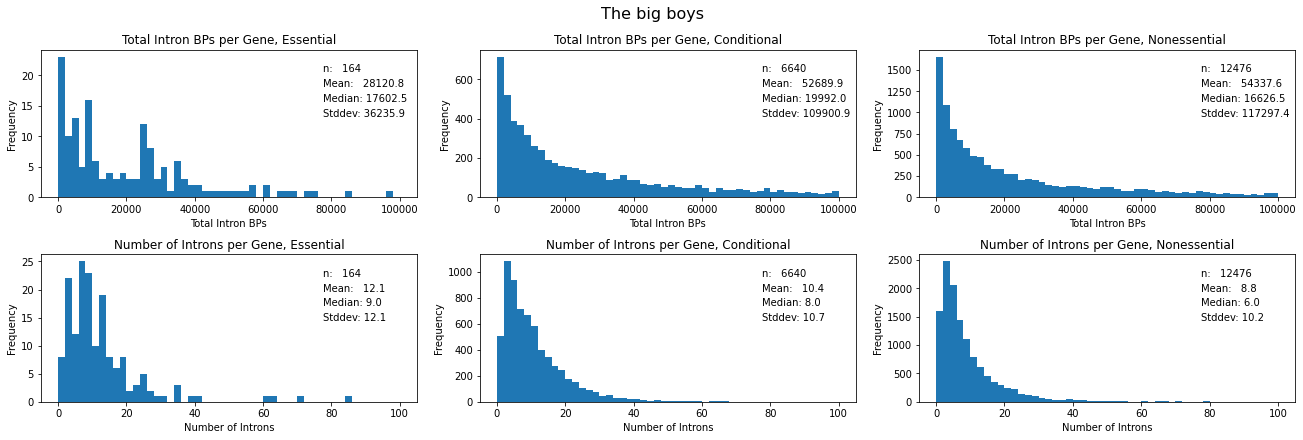

In [11]:
fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(18,6))

for i, ess in enumerate(['Essential', 'Conditional', 'Nonessential']):
    bps_list = gene_bps_by_essentiality(intron_bps_map, essentialities, ess)
    axs[0][i].hist(bps_list, bins=50, rwidth=1, range=(0,100000))
    axs[0][i].set_xlabel('Total Intron BPs')
    axs[0][i].set_title('Total Intron BPs per Gene, ' + ess)
    axs[0][i].set_ylabel('Frequency')

    axs[0][i].text(0.75, 0.85, 'n:   ' + str(len(bps_list)), transform=axs[0][i].transAxes)
    axs[0][i].text(0.75, 0.75, 'Mean:   ' + str(round(np.mean(bps_list), 1)), transform=axs[0][i].transAxes)
    axs[0][i].text(0.75, 0.65, 'Median: ' + str(round(np.median(bps_list), 1)), transform=axs[0][i].transAxes)
    axs[0][i].text(0.75, 0.55, 'Stddev: ' + str(round(np.std(bps_list), 1)), transform=axs[0][i].transAxes)
    
    count_list = gene_counts_by_essentiality(intron_counts_map, essentialities, ess)
    axs[1][i].hist(count_list, bins=50, rwidth=1, range=(0,100))
    axs[1][i].set_xlabel('Number of Introns')
    axs[1][i].set_title('Number of Introns per Gene, ' + ess)
    axs[1][i].set_ylabel('Frequency')

    axs[1][i].text(0.75, 0.85, 'n:   ' + str(len(count_list)), transform=axs[1][i].transAxes)
    axs[1][i].text(0.75, 0.75, 'Mean:   ' + str(round(np.mean(count_list), 1)), transform=axs[1][i].transAxes)
    axs[1][i].text(0.75, 0.65, 'Median: ' + str(round(np.median(count_list), 1)), transform=axs[1][i].transAxes)
    axs[1][i].text(0.75, 0.55, 'Stddev: ' + str(round(np.std(count_list), 1)), transform=axs[1][i].transAxes)

fig.suptitle('The big boys', fontsize=16)
plt.show()

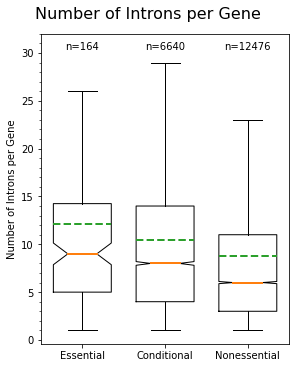

In [103]:
d = []
for i, ess in enumerate(['Essential', 'Conditional', 'Nonessential']):
    d.append(gene_counts_by_essentiality(intron_counts_map, essentialities, ess))

fig, ax = plt.subplots(constrained_layout=True, figsize=(4,5))
ax.boxplot(d, labels=['Essential', 'Conditional', 'Nonessential'], notch=True, showfliers=False, 
           showmeans=True, meanline=True, boxprops=dict(linewidth=1), medianprops=dict(linewidth=2),
           meanprops=dict(linewidth=2), widths=0.7) 
# Add n
for i in range(3):
    ax.text(i+1, 0.95, 'n='+str(len(d[i])), horizontalalignment='center', transform=ax.get_xaxis_transform())
# ax.set_xlabel('Gene Essentiality')
ax.set_ylabel('Number of Introns per Gene')
ax.set_ylim(top=32)
# ax.grid(True)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
# ax.yaxis.grid(which='major', linestyle='dashed', linewidth='0.5', color='lightgray')
# ax.yaxis.grid(which='minor', linestyle='dashed', linewidth='0.5', color='lightgray')
fig.suptitle('Number of Introns per Gene', fontsize=16)
plt.show()

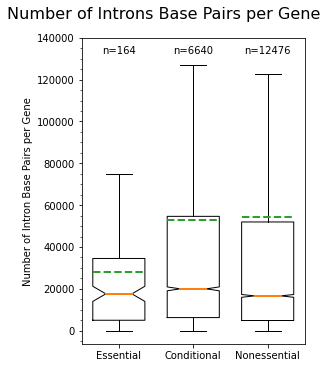

In [107]:
d = []
for i, ess in enumerate(['Essential', 'Conditional', 'Nonessential']):
    d.append(gene_bps_by_essentiality(intron_bps_map, essentialities, ess))

fig, ax = plt.subplots(constrained_layout=True, figsize=(4,5))
ax.boxplot(d, labels=['Essential', 'Conditional', 'Nonessential'], notch=True, showfliers=False, 
           showmeans=True, meanline=True, boxprops=dict(linewidth=1), medianprops=dict(linewidth=2),
           meanprops=dict(linewidth=2), widths=0.7) 
# Add n
for i in range(3):
    ax.text(i+1, 0.95, 'n='+str(len(d[i])), horizontalalignment='center', transform=ax.get_xaxis_transform())
# ax.set_xlabel('Gene Essentiality')
ax.set_ylabel('Number of Intron Base Pairs per Gene')
ax.set_ylim(top=140000)
# ax.grid(True)
ax.minorticks_on()
ax.tick_params(axis='x', which='minor', bottom=False)
# ax.yaxis.grid(which='major', linestyle='dashed', linewidth='0.5', color='lightgray')
# ax.yaxis.grid(which='minor', linestyle='dashed', linewidth='0.5', color='lightgray')
fig.suptitle('Number of Introns Base Pairs per Gene', fontsize=16)
plt.show()

In [12]:
# Now, look at only essential genes
# Identiy [AT|GT]ATCCT....[AG|AC] patterns (U12), and correlate with number of introns and number of base pairs
# Returns: intron_bps, intron_counts
#      intron_bps = array of # bps in NNATCCT genes
#      intron_counts = array of # introns in NNATCCT genes
def find_ATCCT_pattern(essentialities, intron_bps_map, intron_counts_map, opposite_pattern=False):
    
    # find all genes containing introns with ATCCT
    ATCCT_genes = set()
    with open('introns.csv') as f:
        for _ in tqdm(range(num_lines), position=0, leave=True):
            line = f.readline().split(',')
            gene = line[0]
            code = line[4][:-1]
                
            # Ignore introns with no essentiality info
            if gene not in essentialities:
                continue
            
            # Ignore genes that are not essential
            if essentialities[gene] != ESSENTIALITY_DICT['Essential']:
                continue
            
            matches_pattern = (code[:7] == 'ATATCCT' or code[:7] == 'GTATCCT') and (code[-2:] == 'AG' or code[-2:] == 'AC')
            if (matches_pattern and not opposite_pattern) or (not matches_pattern and opposite_pattern):
                ATCCT_genes.add(gene)
                
#                 print('wow')
    
    # convert set to list; this is done so we don't have duplicates
    ATCCT_genes = list(ATCCT_genes)
    intron_bps = []
    intron_counts = []
    for gene in ATCCT_genes:
        intron_bps.append(intron_bps_map[gene])
        intron_counts.append(intron_counts_map[gene])
    
    return intron_bps, intron_counts

In [13]:
intron_bps, intron_counts = find_ATCCT_pattern(essentialities, intron_bps_map, intron_counts_map)
intron_bps_opp, intron_counts_opp = find_ATCCT_pattern(essentialities, intron_bps_map, intron_counts_map, opposite_pattern=True)

100%|██████████| 248692/248692 [00:03<00:00, 72118.06it/s]


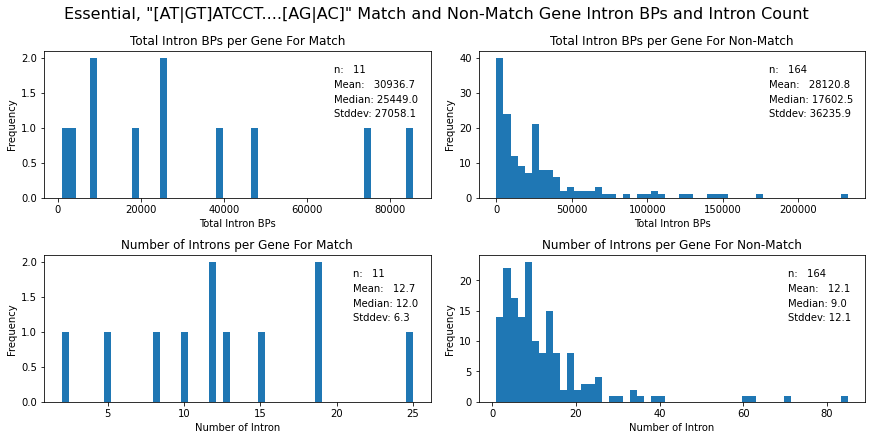

In [14]:
fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(12,6))

for (i, bps) in enumerate([intron_bps, intron_bps_opp]):
    axs[0][i].hist(bps, bins=50, rwidth=1)
    axs[0][i].set_xlabel('Total Intron BPs')
    axs[0][i].set_title('Total Intron BPs per Gene' + (' For Non-Match' if i == 1 else ' For Match'))
    axs[0][i].set_ylabel('Frequency')

    axs[0][i].text(0.75, 0.85, 'n:   ' + str(len(bps)), transform=axs[0][i].transAxes)
    axs[0][i].text(0.75, 0.75, 'Mean:   ' + str(round(np.mean(bps), 1)), transform=axs[0][i].transAxes)
    axs[0][i].text(0.75, 0.65, 'Median: ' + str(round(np.median(bps), 1)), transform=axs[0][i].transAxes)
    axs[0][i].text(0.75, 0.55, 'Stddev: ' + str(round(np.std(bps), 1)), transform=axs[0][i].transAxes)

for (i, counts) in enumerate([intron_counts, intron_counts_opp]):
    axs[1][i].hist(counts, bins=50, rwidth=1)
    axs[1][i].set_xlabel('Number of Intron')
    axs[1][i].set_title('Number of Introns per Gene' + (' For Non-Match' if i == 1 else ' For Match'))
    axs[1][i].set_ylabel('Frequency')

    axs[1][i].text(0.8, 0.85, 'n:   ' + str(len(counts)), transform=axs[1][i].transAxes)
    axs[1][i].text(0.8, 0.75, 'Mean:   ' + str(round(np.mean(counts), 1)), transform=axs[1][i].transAxes)
    axs[1][i].text(0.8, 0.65, 'Median: ' + str(round(np.median(counts), 1)), transform=axs[1][i].transAxes)
    axs[1][i].text(0.8, 0.55, 'Stddev: ' + str(round(np.std(counts), 1)), transform=axs[1][i].transAxes)
        
fig.suptitle('Essential, "[AT|GT]ATCCT....[AG|AC]" Match and Non-Match Gene Intron BPs and Intron Count', fontsize=16)
plt.show()